nodes:  484 links  861
Total shortest path length (Euclidean distance): 21863830.819518004
Total length of all edges (Euclidean distance): 4908.4204630793365
Total length of Minimum Spanning Tree (Euclidean distance): 1834.3716186441638


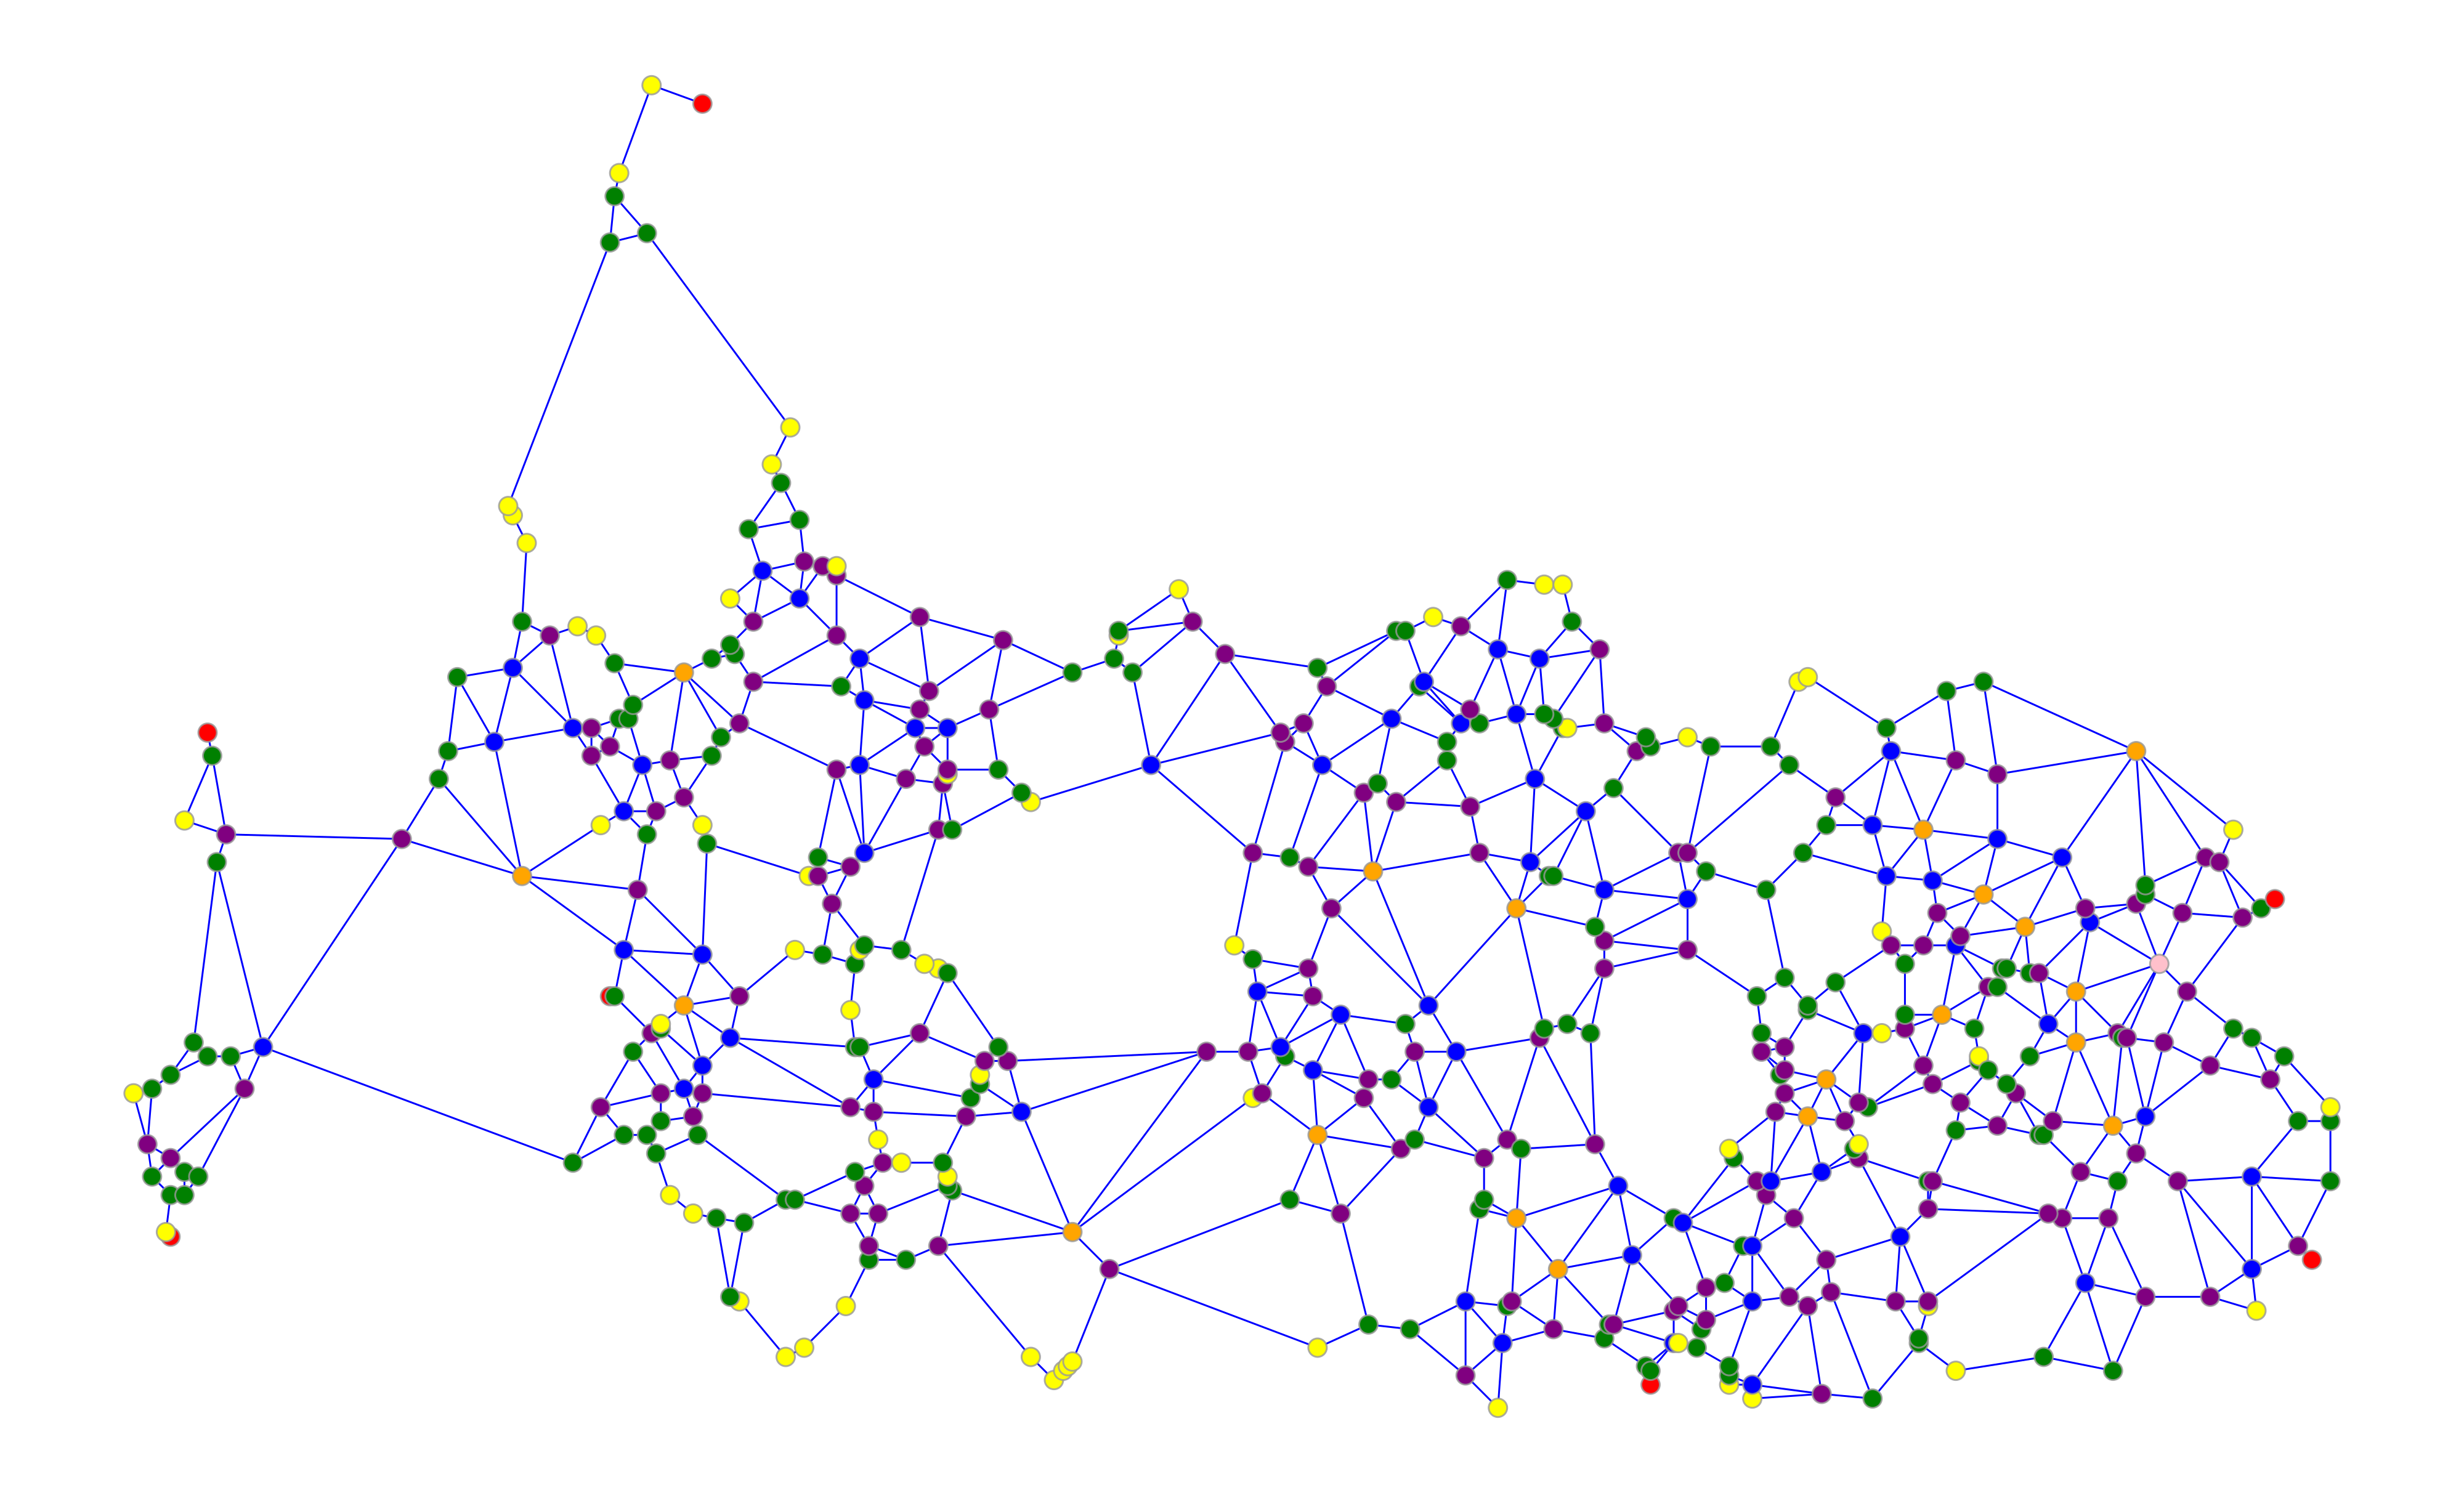

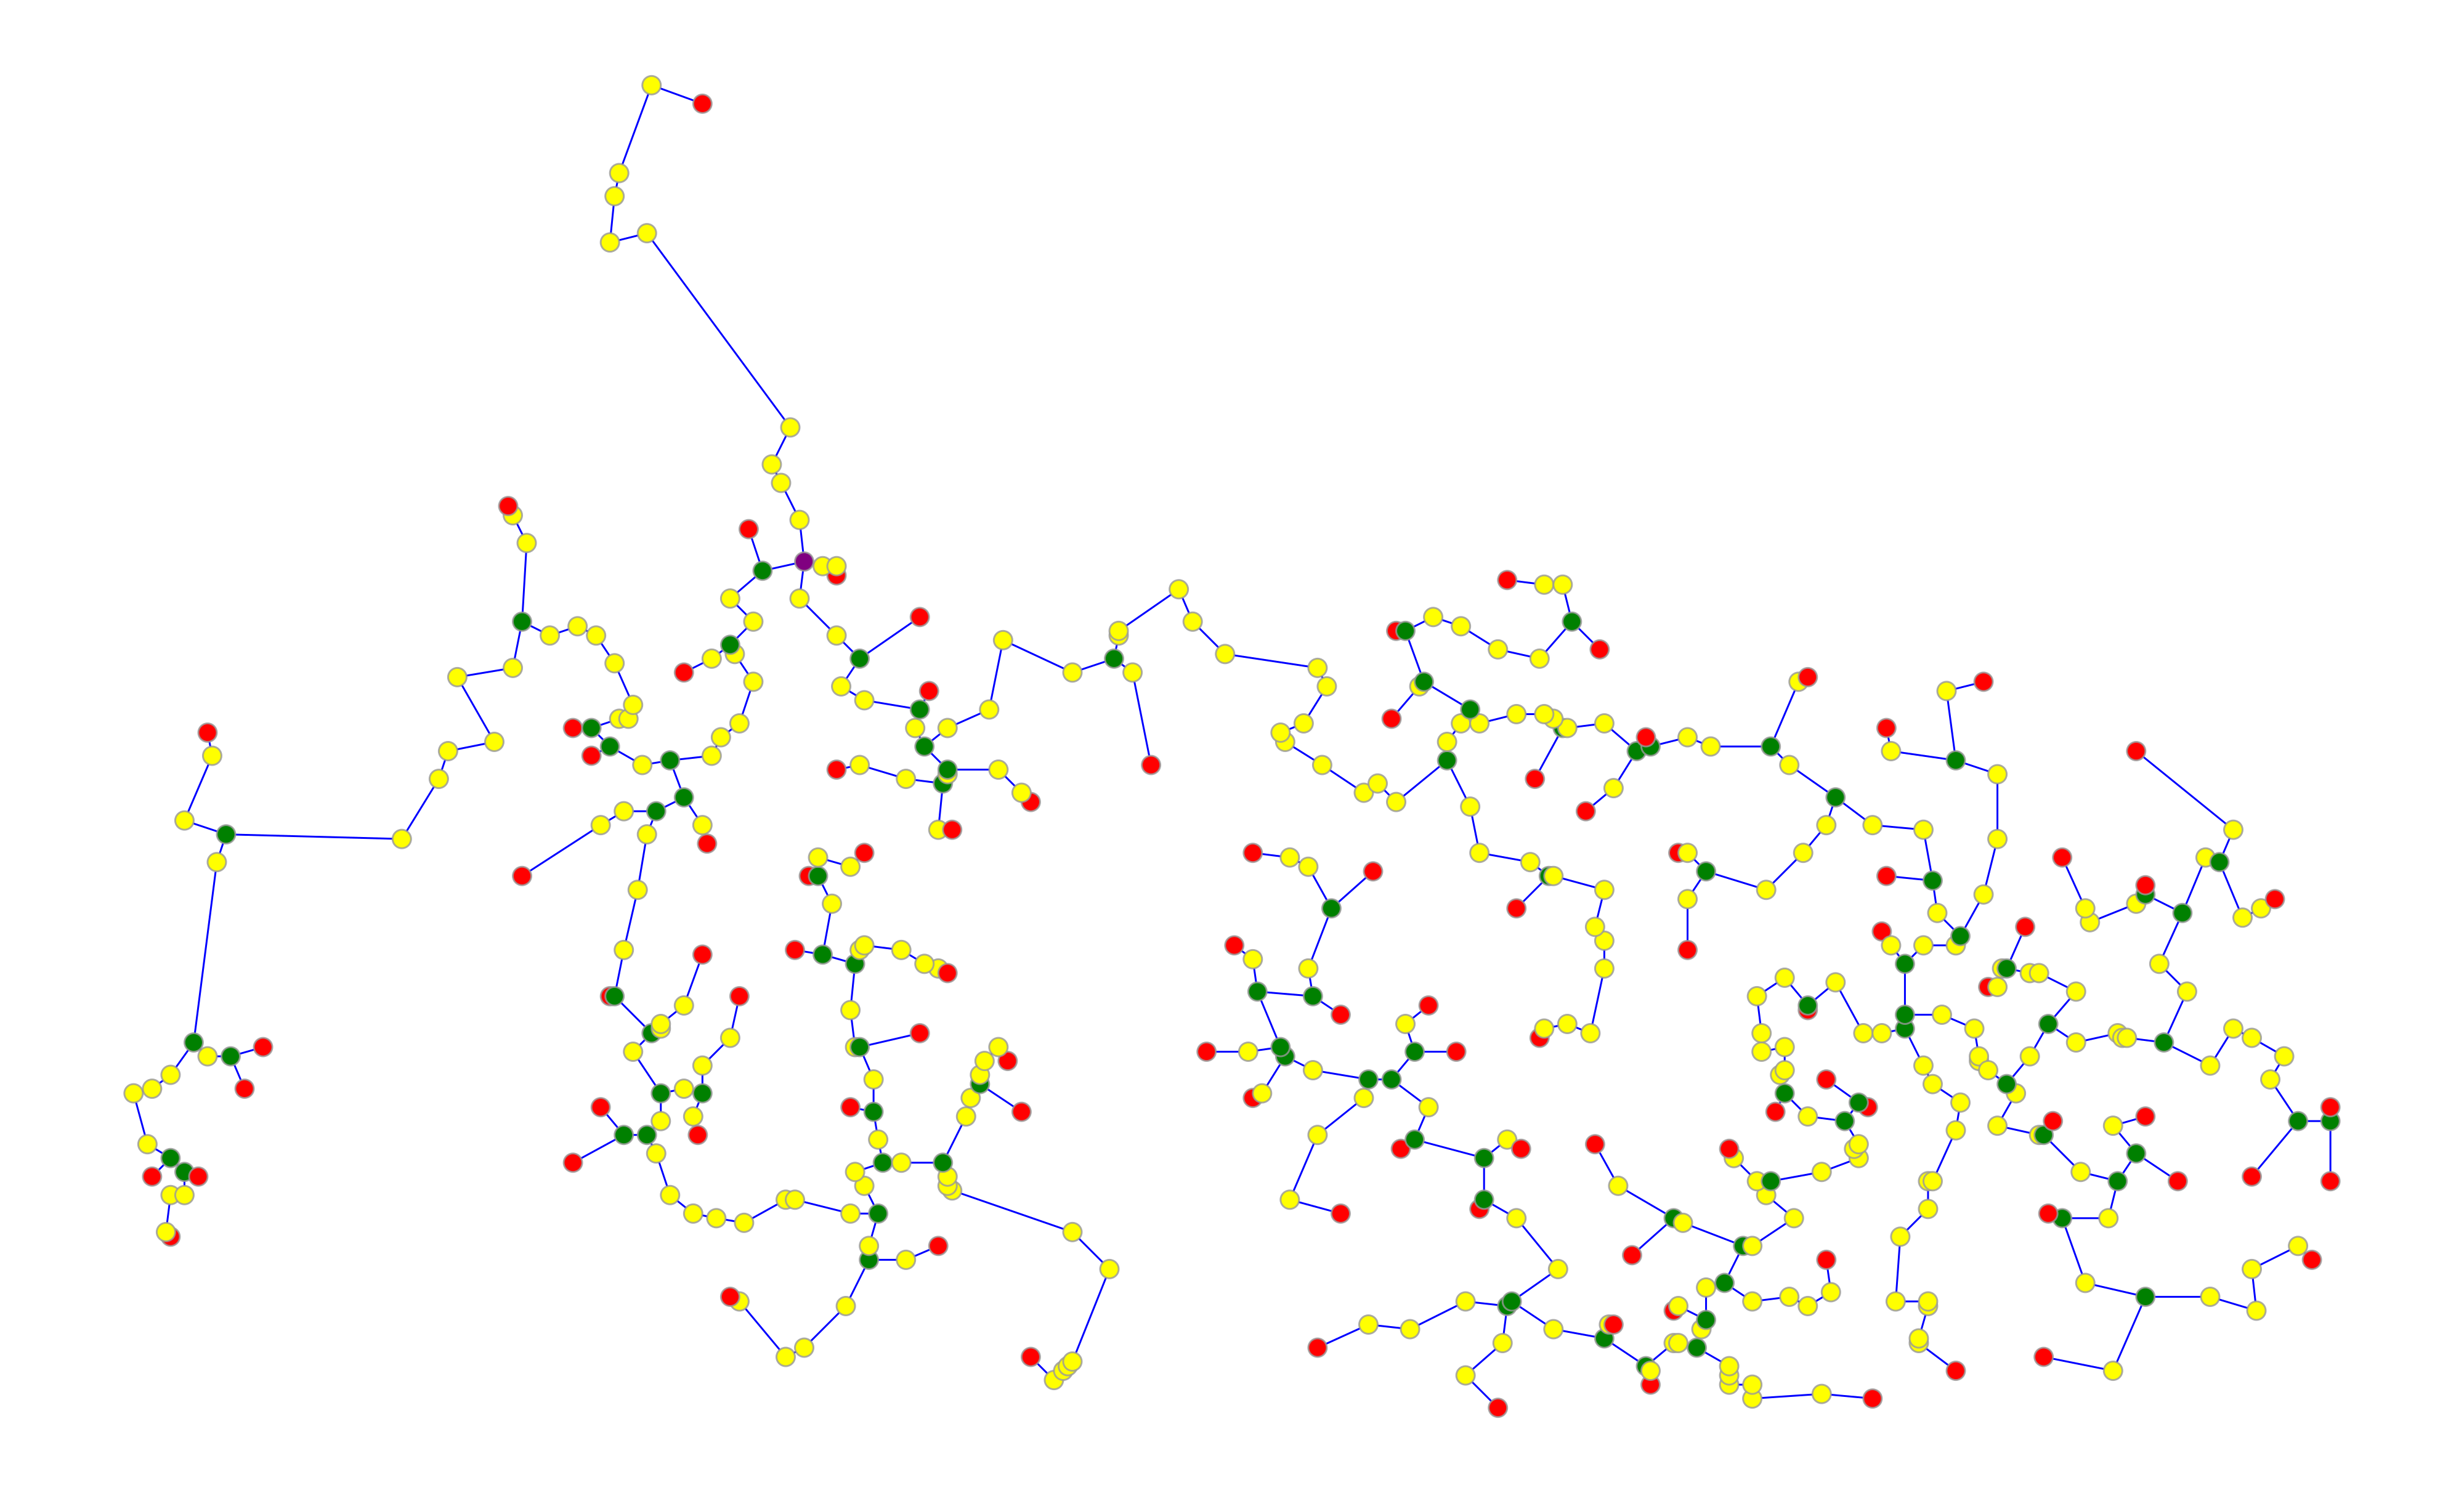

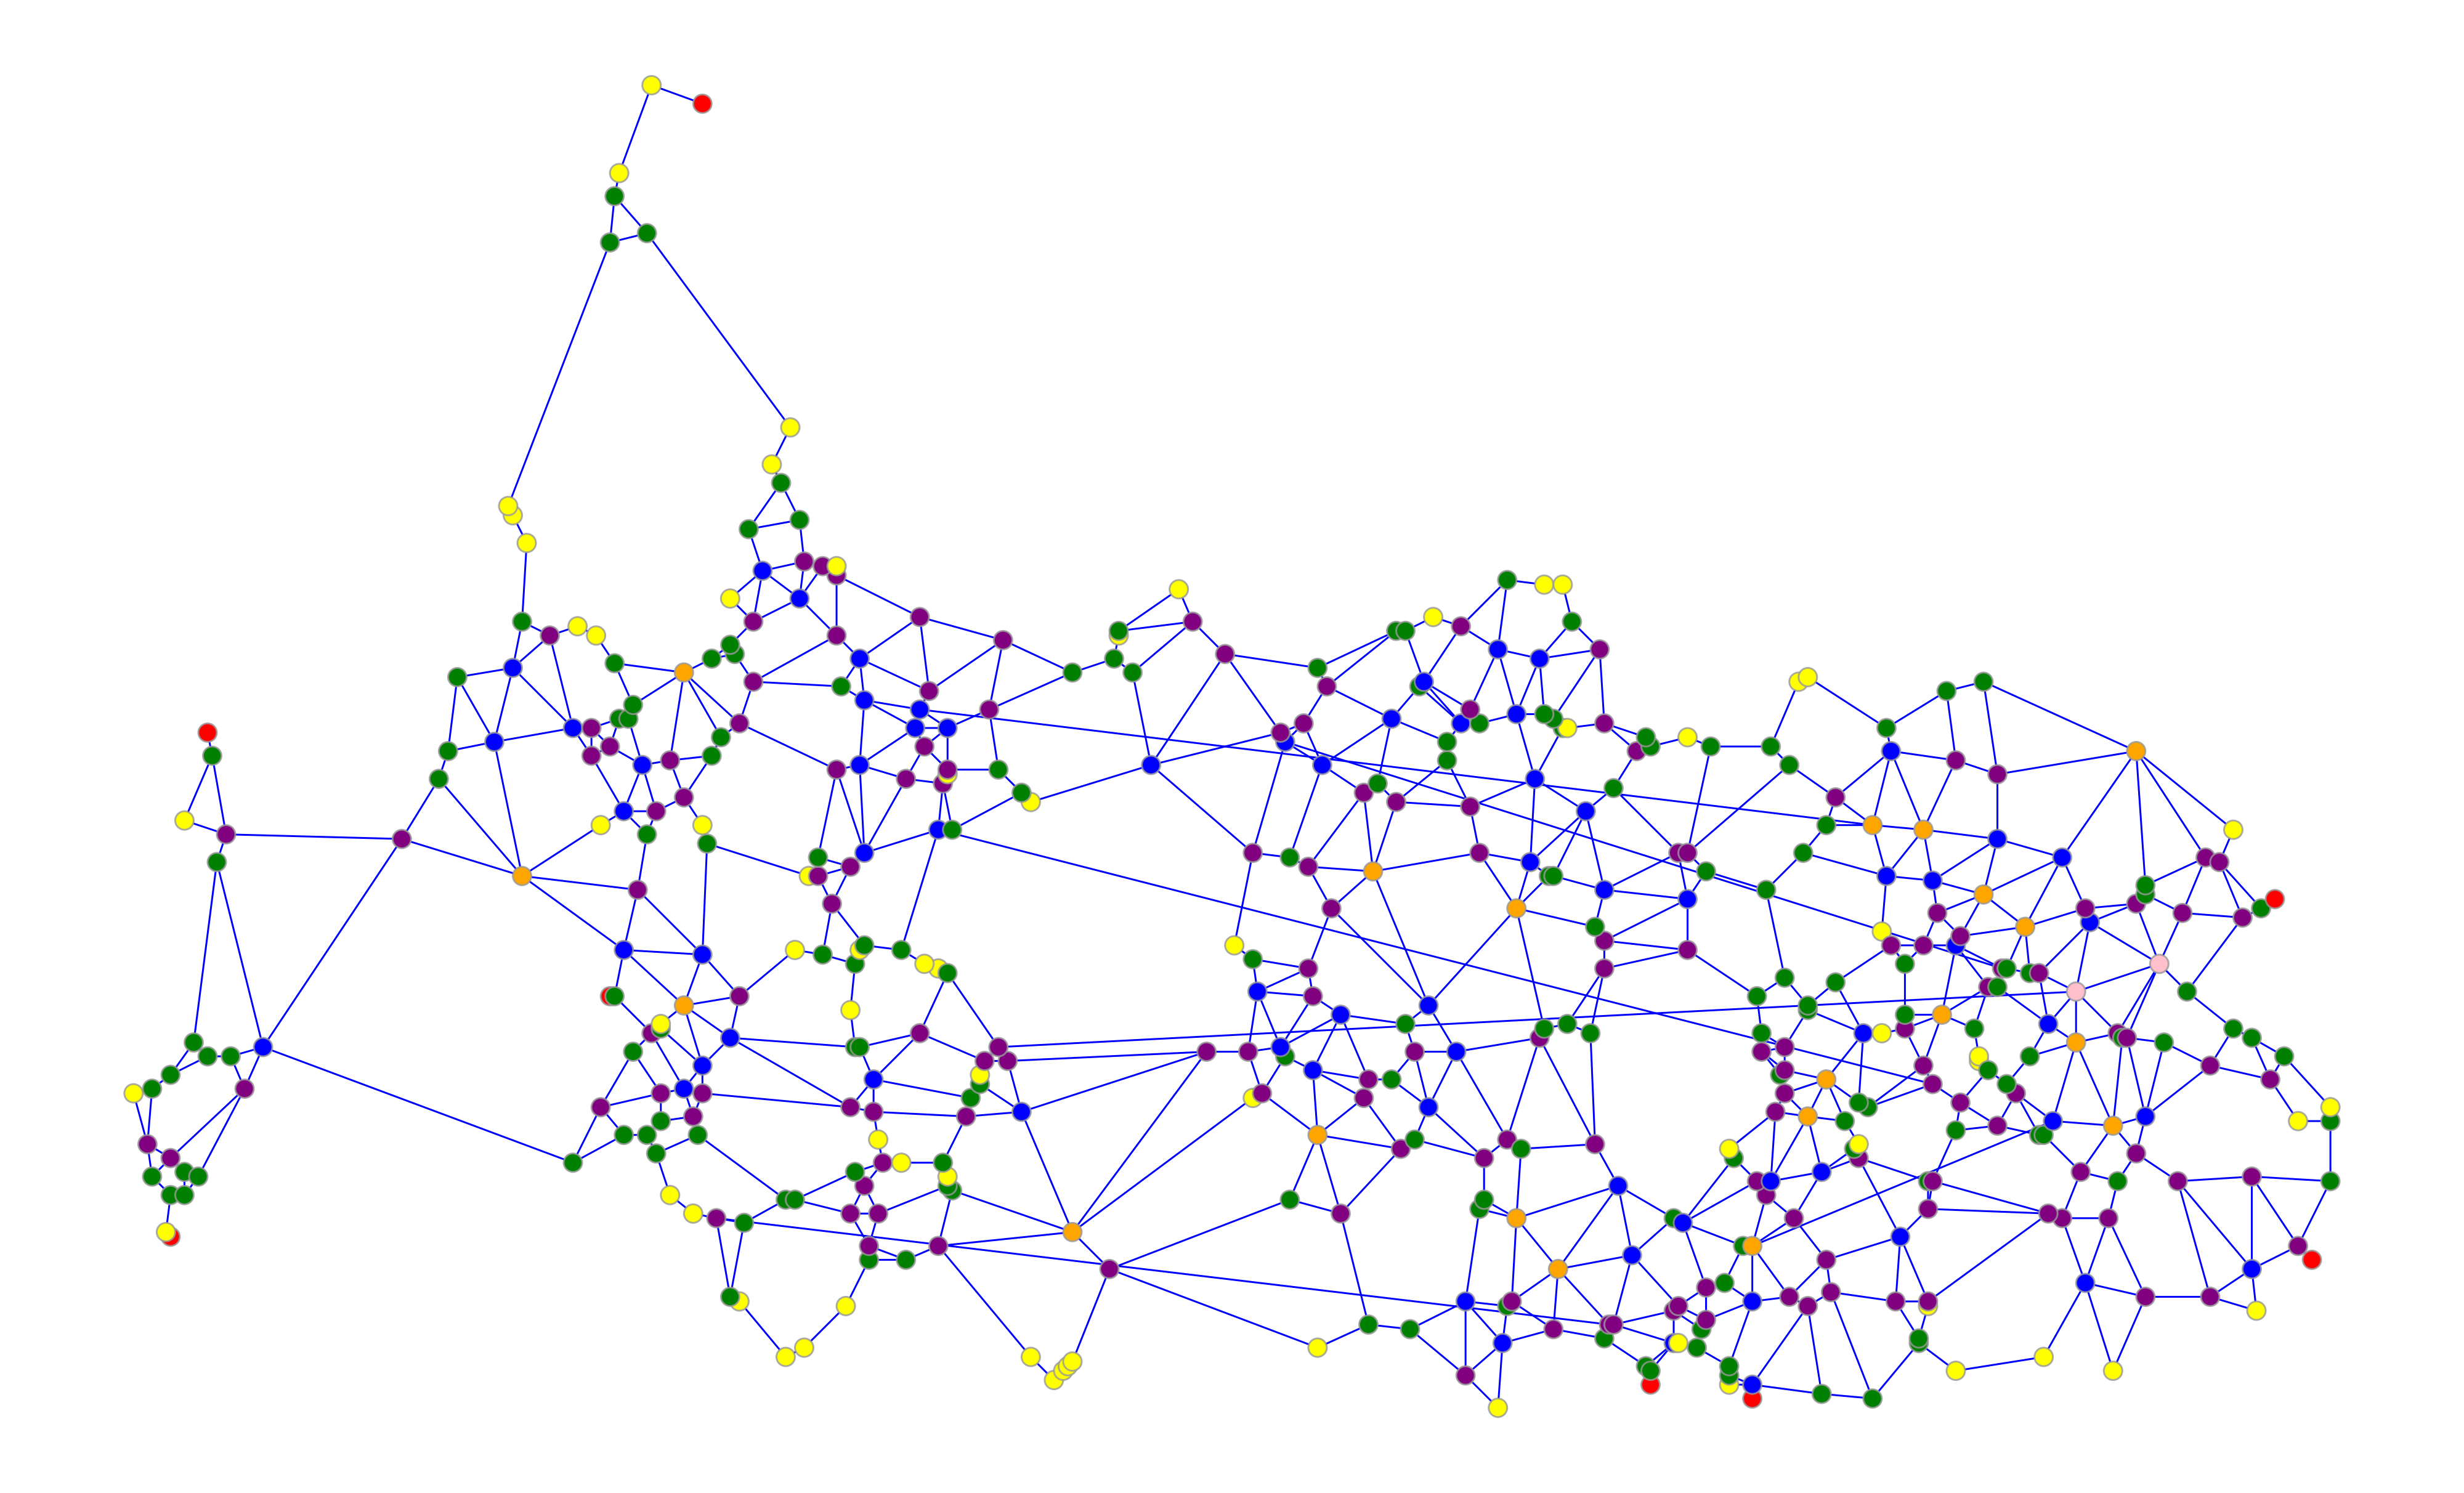

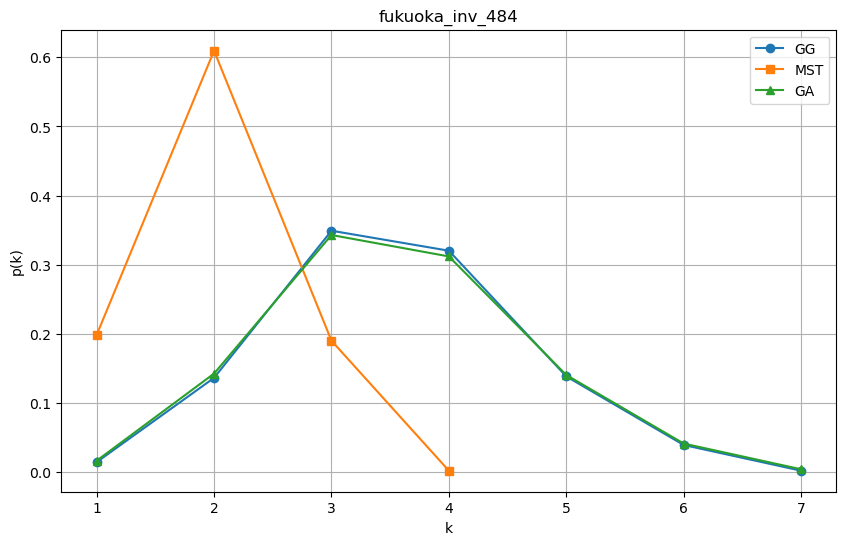

In [10]:
from graph_tool.all import graph_draw, Graph, shortest_distance, min_spanning_tree, vertex_hist
import python_codes.files_operators
import numpy as np
import matplotlib.pyplot as plt

# 读取网络文件
types = 'gg'
city = 'fukuoka'
sort = 'ascend'
scale = '484'
read_graph, read_pos = python_codes.files_operators.read_files(
    f"../networks_clusters/{city}_{sort}_{scale}_{types}.net", True)
read_graph_ga, read_pos_ga = python_codes.files_operators.read_files(
    f"../networks_clusters/{city}_{sort}_{scale}_{types}_ga.net", False)

print("nodes: ", read_graph.num_vertices(), "links ", read_graph.num_edges())

# 计算并添加边的欧氏距离作为权重属性
edge_weights = read_graph.new_edge_property("double")
for edge in read_graph.edges():
    source_pos = read_pos[edge.source()]
    target_pos = read_pos[edge.target()]
    euclidean_distance = np.sqrt((source_pos[0] - target_pos[0]) ** 2 + (source_pos[1] - target_pos[1]) ** 2)
    edge_weights[edge] = euclidean_distance

# 计算最短路径总和
dist_matrix = shortest_distance(read_graph, weights=edge_weights).get_2d_array(range(read_graph.num_vertices()))
total_distance = np.sum(dist_matrix[dist_matrix != np.inf])

# 打印最短路径总和
print("Total shortest path length (Euclidean distance):", total_distance)

# 计算所有边的总长度
all_edges_length = np.sum([edge_weights[edge] for edge in read_graph.edges()])

# 打印所有边的总长度
print("Total length of all edges (Euclidean distance):", all_edges_length)

# 生成最小生成树
mst_edges = min_spanning_tree(read_graph, weights=edge_weights)
mst_graph = Graph(directed=False)
mst_graph.add_vertex(read_graph.num_vertices())
mst_graph.add_edge_list((int(e.source()), int(e.target())) for e in read_graph.edges() if mst_edges[e])

# 创建最小生成树的节点位置属性
mst_pos = mst_graph.new_vertex_property("vector<double>")
for v in mst_graph.vertices():
    mst_pos[v] = read_pos[v]

# 打印最小生成树的边和
mst_total_length = np.sum([edge_weights[edge] for edge in read_graph.edges() if mst_edges[edge]])
print("Total length of Minimum Spanning Tree (Euclidean distance):", mst_total_length)

# 设置节点颜色属性
vertex_degrees = read_graph.get_total_degrees(read_graph.get_vertices())
vertex_colors = read_graph.new_vertex_property("string")
color_map = ['red', 'yellow', 'green', 'purple', 'blue', 'orange', 'pink', 'brown', 'cyan']
for v in read_graph.vertices():
    degree = int(vertex_degrees[int(v)])
    if degree <= 8:
        vertex_colors[v] = color_map[degree - 1]
    else:
        vertex_colors[v] = 'gray'

# 设置最小生成树节点颜色属性
mst_vertex_degrees = mst_graph.get_total_degrees(mst_graph.get_vertices())
mst_vertex_colors = mst_graph.new_vertex_property("string")
for v in mst_graph.vertices():
    degree = int(mst_vertex_degrees[int(v)])
    if degree <= 8:
        mst_vertex_colors[v] = color_map[degree - 1]
    else:
        mst_vertex_colors[v] = 'gray'

# 设置ga节点颜色属性
ga_vertex_degrees = read_graph_ga.get_total_degrees(read_graph_ga.get_vertices())
ga_vertex_colors = read_graph_ga.new_vertex_property("string")
color_map = ['red', 'yellow', 'green', 'purple', 'blue', 'orange', 'pink', 'brown', 'cyan']
for v in read_graph_ga.vertices():
    degree = int(ga_vertex_degrees[int(v)])
    if degree <= 8:
        ga_vertex_colors[v] = color_map[degree - 1]
    else:
        ga_vertex_colors[v] = 'gray'

# 绘制原始网络和最小生成树
graph_draw(read_graph, read_pos, vertex_size=15, edge_color='blue', vertex_fill_color=vertex_colors,
           output_size=(2000, 2000))
graph_draw(read_graph, read_pos, vertex_size=15, edge_color='blue', vertex_fill_color=vertex_colors,
           output_size=(2000, 2000),
           output=f'output3/{city}_inv_{scale}_{types}_network.png')

graph_draw(mst_graph, mst_pos, vertex_size=15, edge_color='blue', vertex_fill_color=mst_vertex_colors,
           output_size=(2000, 2000))
graph_draw(mst_graph, mst_pos, vertex_size=15, edge_color='blue', vertex_fill_color=mst_vertex_colors,
           output_size=(2000, 2000),
           output=f'output3/{city}_inv_{scale}_mst_only.png')

graph_draw(read_graph_ga, read_pos_ga, vertex_size=15, edge_color='blue', vertex_fill_color=ga_vertex_colors,
           output_size=(2000, 2000))
graph_draw(read_graph_ga, read_pos_ga, vertex_size=15, edge_color='blue', vertex_fill_color=ga_vertex_colors,
           output_size=(2000, 2000),
           output=f'output3/{city}_inv_{scale}_{types}_ga_network.png')

# 计算三个网络的度分布
hist_read = vertex_hist(read_graph, "total")
hist_mst = vertex_hist(mst_graph, "total")
hist_ga = vertex_hist(read_graph_ga, "total")

# 绘制度分布折线图
plt.figure(figsize=(10, 6))
x_read = np.arange(1, len(hist_read[0]))  # 去掉度数为0的节点
x_mst = np.arange(1, len(hist_mst[0]))  # 去掉度数为0的节点
x_ga = np.arange(1, len(hist_ga[0]))

plt.plot(x_read, hist_read[0][1:] / sum(hist_read[0][1:]), label='GG', marker='o')
plt.plot(x_mst, hist_mst[0][1:] / sum(hist_mst[0][1:]), label='MST', marker='s')
plt.plot(x_ga, hist_ga[0][1:] / sum(hist_ga[0][1:]), label='GA', marker='^')

plt.xlabel('k')
plt.ylabel('p(k)')
plt.title(f'{city}_inv_{scale}')
plt.legend()
plt.grid(True)
ax = plt.gca()
plt.savefig(f'output3/{city}_inv_{scale}_degree_distribution.png')


nodes:  484 links  861


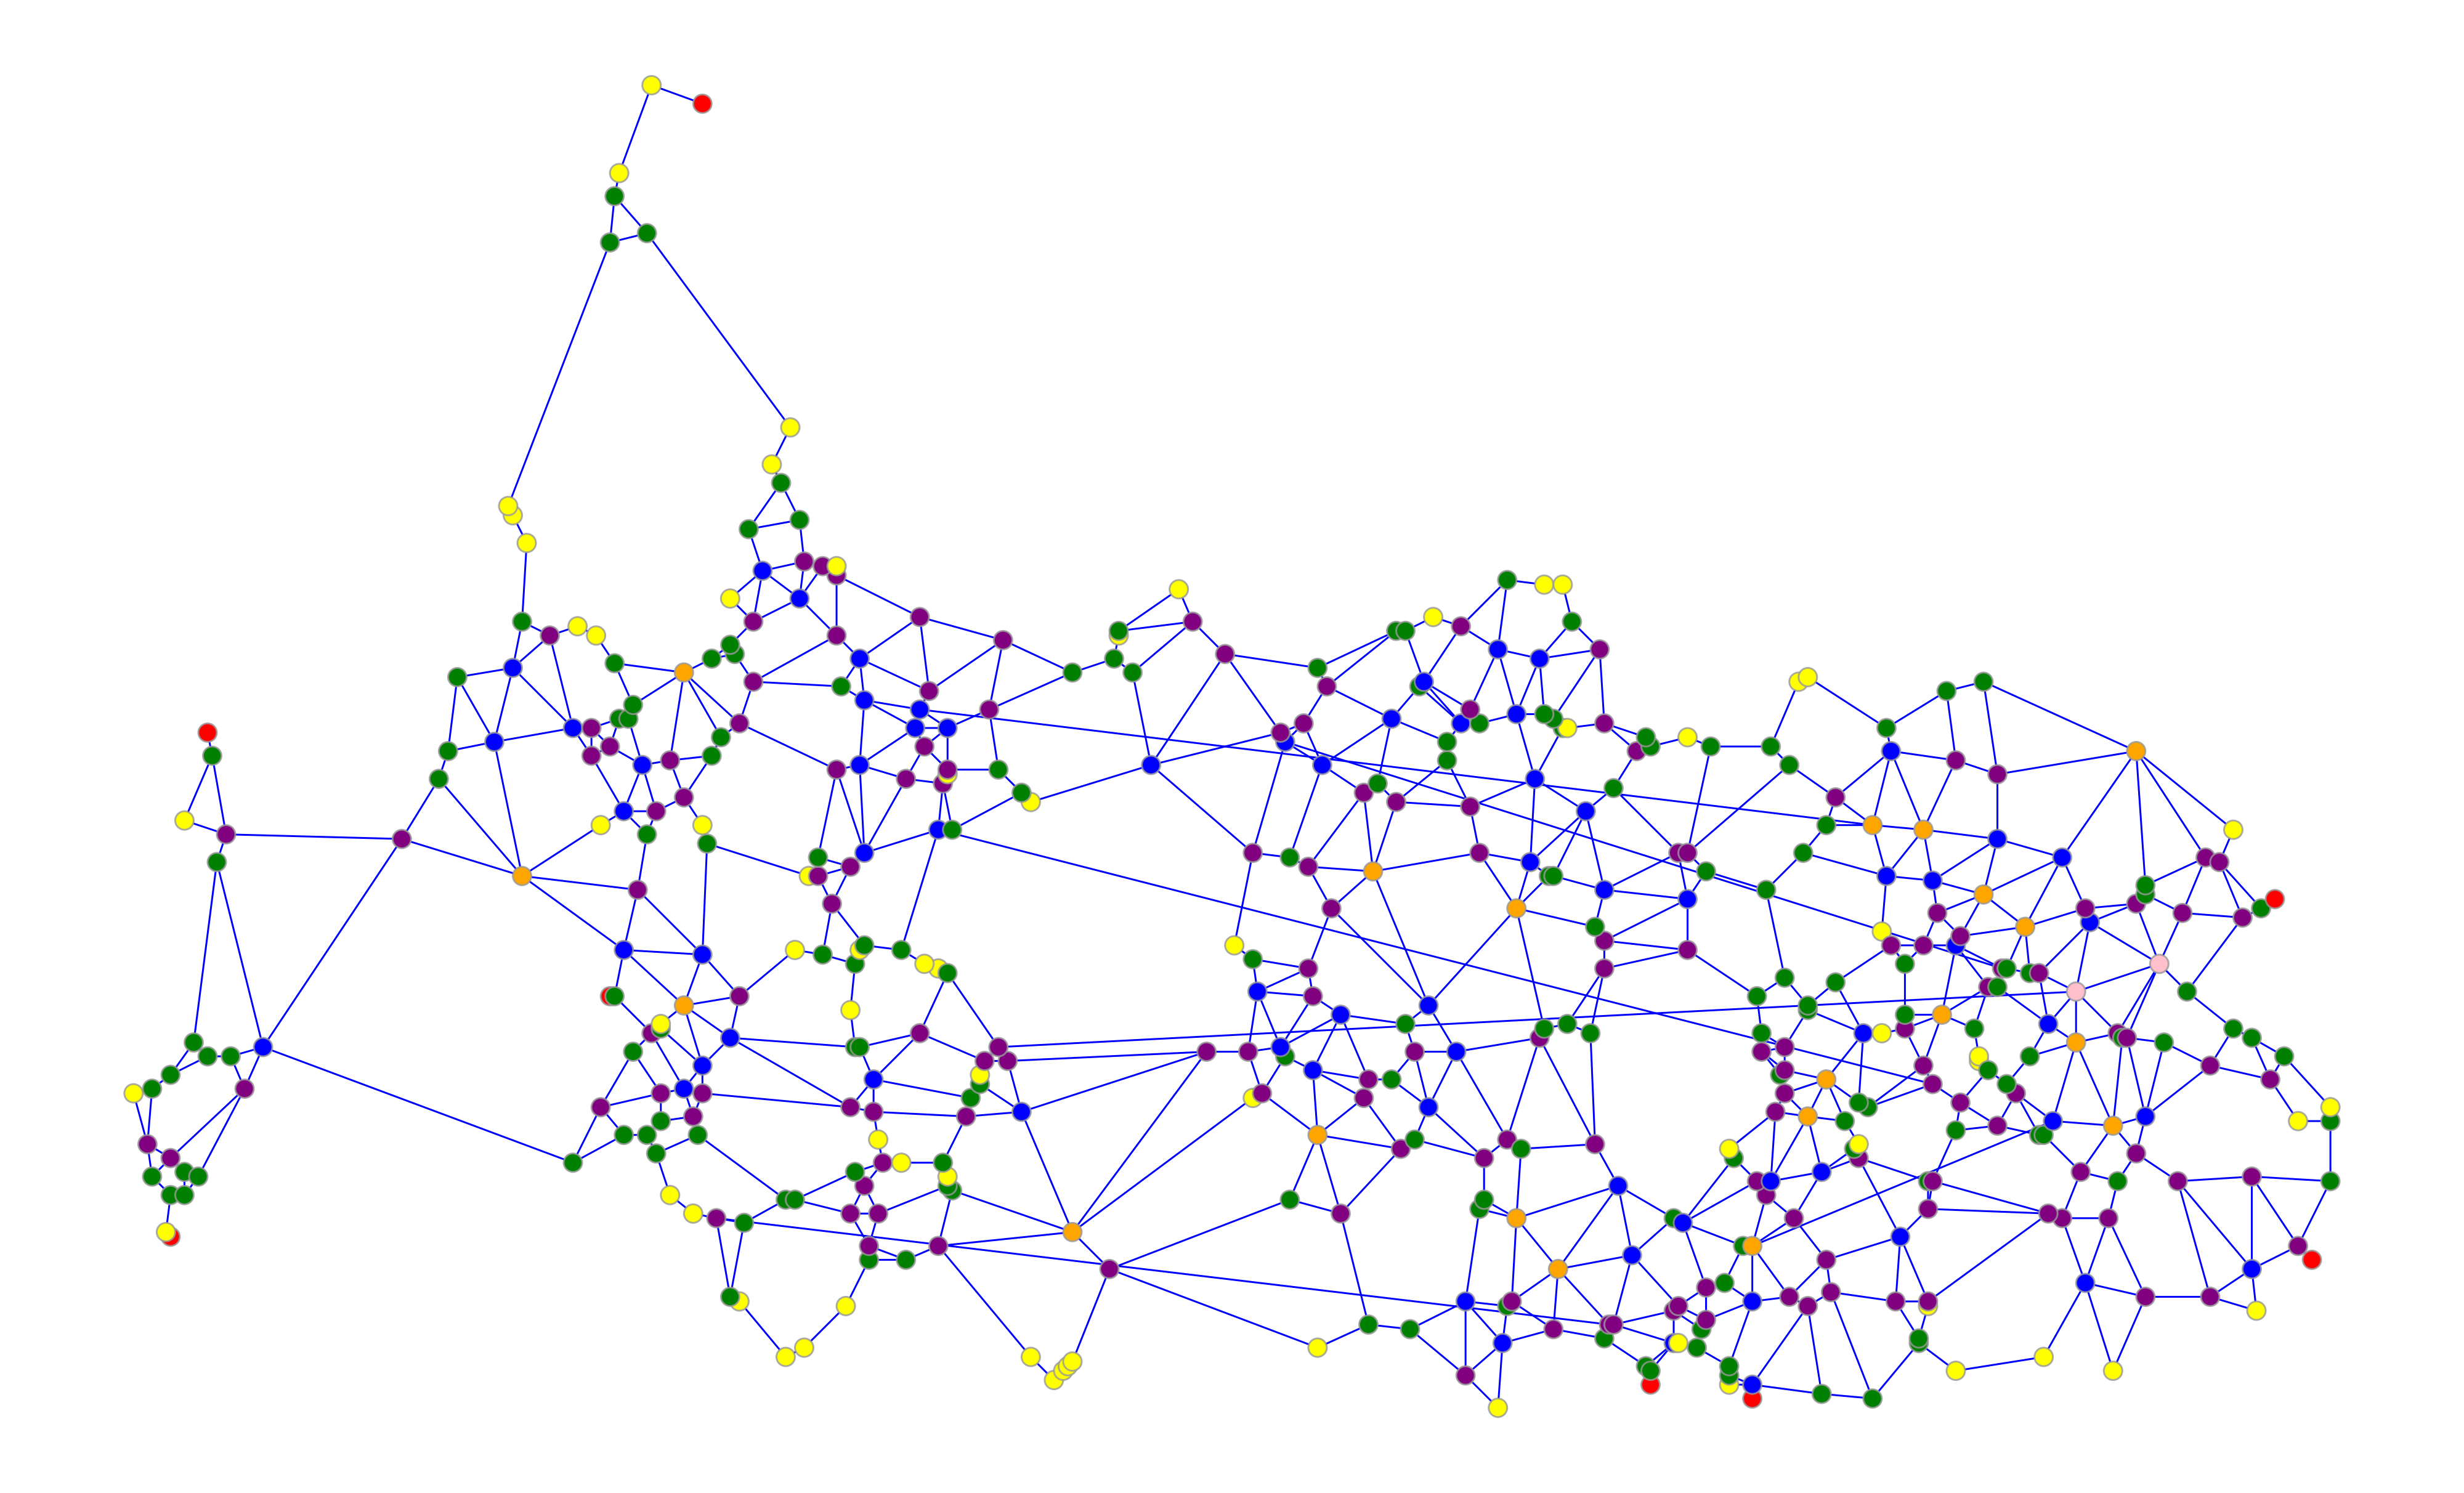

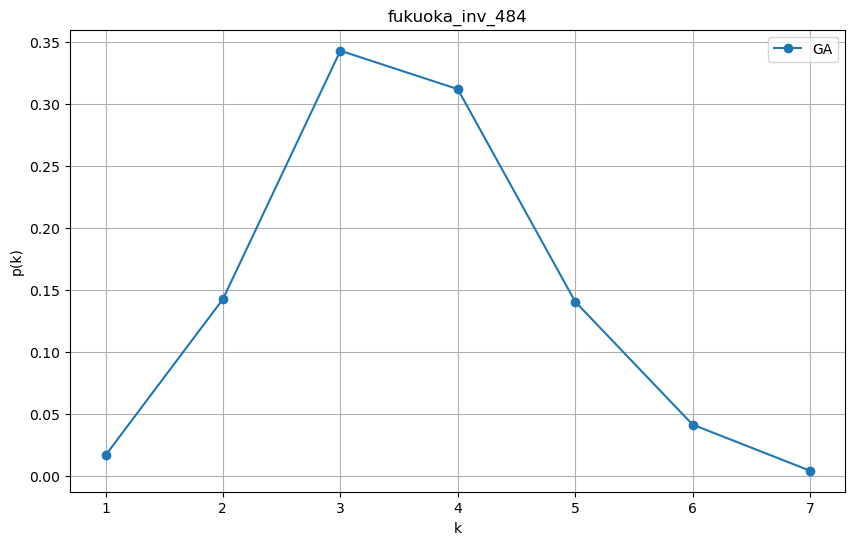

In [9]:
read_graph_ga, read_pos_ga = python_codes.files_operators.read_files(
    f"../networks_clusters/{city}_{sort}_{scale}_{types}_ga.net", False)

# 设置ga节点颜色属性
ga_vertex_degrees = read_graph_ga.get_total_degrees(read_graph_ga.get_vertices())
ga_vertex_colors = read_graph_ga.new_vertex_property("string")
color_map = ['red', 'yellow', 'green', 'purple', 'blue', 'orange', 'pink', 'brown', 'cyan']
for v in read_graph_ga.vertices():
    degree = int(ga_vertex_degrees[int(v)])
    if degree <= 8:
        ga_vertex_colors[v] = color_map[degree - 1]
    else:
        ga_vertex_colors[v] = 'gray'

# 绘制ga网络
graph_draw(read_graph_ga, read_pos_ga, vertex_size=15, edge_color='blue', vertex_fill_color=ga_vertex_colors,
           output_size=(2000, 2000))
graph_draw(read_graph_ga, read_pos_ga, vertex_size=15, edge_color='blue', vertex_fill_color=ga_vertex_colors,
           output_size=(2000, 2000),
           output=f'output3/{city}_inv_{scale}_{types}_network.png')

# 计算三个网络的度分布
hist_ga = vertex_hist(read_graph_ga, "total")

# 绘制度分布折线图
plt.figure(figsize=(10, 6))
x_read = np.arange(1, len(hist_ga[0]))  # 去掉度数为0的节点

plt.plot(x_read, hist_ga[0][1:] / sum(hist_ga[0][1:]), label='GA', marker='o')

plt.xlabel('k')
plt.ylabel('p(k)')
plt.title(f'{city}_inv_{scale}')
plt.legend()
plt.grid(True)
ax = plt.gca()
plt.savefig(f'output3/{city}_inv_{scale}_degree_distribution.png')
